# Extracting a pore network using PoreSpy and loading into OpenPNM


In [1]:
import warnings
import scipy as sp
import numpy as np
import porespy as ps
import openpnm as op
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
ws = op.Workspace()
ws.settings["loglevel"] = 40
warnings.filterwarnings('ignore')
%matplotlib inline
np.random.seed(10)

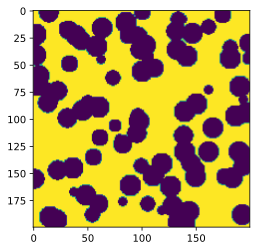

In [2]:
im = ps.generators.overlapping_spheres(shape=[200, 200, 200], radius=10,
                                       porosity=0.5, iter_max=0)
plt.imshow(im[:, :, 50]);

Let's check out the porosity of the generated image!

In [3]:
eps = ps.metrics.porosity(im)
print(f"Porosity: {eps*100:.1f}%")

Porosity: 62.0%


Let's visualize the image using `porespy`'s 3D visualizer: (this might take several seconds)

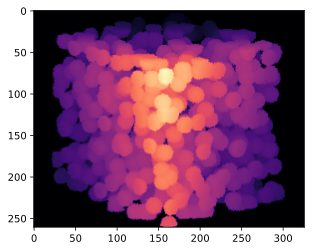

In [4]:
im_3d = ps.visualization.show_3D(im)
plt.imshow(im_3d, cmap=plt.cm.magma);

In [5]:
snow = ps.networks.snow(im=im, boundary_faces=['right'])

------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  750
Peaks after trimming saddle points:  542
Peaks after trimming nearby peaks:  532
------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████| 585/585 [00:05<00:00, 107.10it/s]


OpenPNM has an IO class specifically for importing the output from PoreSpy.  The ``import_data`` method can either accept a handle to a dictionary (as output from the ``snow`` algorithm above), or it can accept a filename to a saved dctionary (saved using Python's ``pickle`` library).  All IO methods in OpenPNM return a ``project`` which is a ``list``, in this case containing a network and a geometry object.  

In [6]:
proj = op.io.PoreSpy.import_data(snow)
print(proj)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
 Object Name     Object ID                                                        
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
 net_01          <openpnm.network.GenericNetwork object at 0x7fe5a7acbbd0>        
 geo_01          <openpnm.geometry.Imported object at 0x7fe5a7acb770>             
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


We can unpack the network and geometry objects from the ``project`` using the indices in the list as follows:

In [7]:
net = proj[0]
geo = proj[1]
print(net)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
openpnm.network.GenericNetwork : net_01
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Properties                                    Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.coords                                     585 / 585  
2     throat.conns                                   2054 / 2054 
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Labels                                        Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.all                                      585       
2     pore.boundary                                 53        
3     pore.geo_01                                   585       
4     pore.internal                                 532       
5     pore.right                             

It is important to note that the ``net`` object only has topological information and labels.  The ``geo`` object was created by the ``openpnm.io.PoreSpy`` import class to extract all geometric information from the supplied ``snow`` dict and put in on a geometry object.  We can print ``geo`` to confirm:

In [8]:
print(geo)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
openpnm.geometry.Imported : geo_01
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Properties                                    Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.area                                       585 / 585  
2     pore.centroid                                   585 / 585  
3     pore.diameter                                   585 / 585  
4     pore.equivalent_diameter                        585 / 585  
5     pore.extended_diameter                          585 / 585  
6     pore.inscribed_diameter                         585 / 585  
7     pore.label                                      585 / 585  
8     pore.region_volume                              585 / 585  
9     pore.surface_area                               585 / 585  
10    pore.volume                                     585 / 585  
11 

Now let's plot things to see what we have:

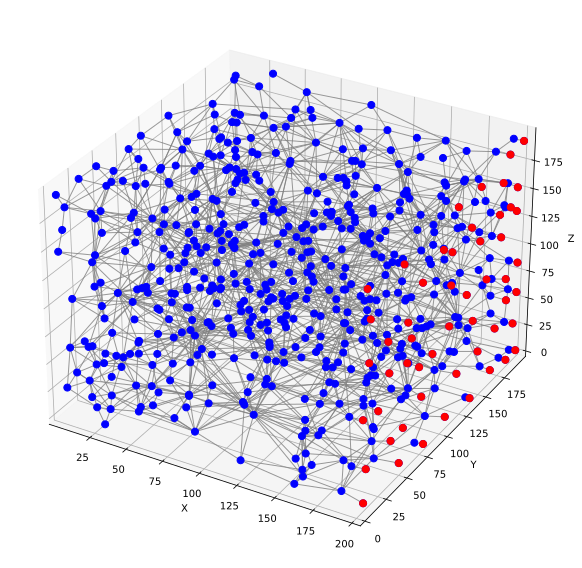

In [9]:
# NBVAL_IGNORE_OUTPUT
fig, ax = plt.subplots(figsize=(8, 8))
op.topotools.plot_connections(network=net, alpha=0.8, color='grey', ax=ax)
op.topotools.plot_coordinates(network=net, ax=ax, color='b', markersize=50)
op.topotools.plot_coordinates(network=net, pores=net.pores('right'),
                              ax=ax, color='r', markersize=50)
fig.tight_layout()

This looks pretty good, but it only has boundary pores on the right face, indicated by the red dots.  When we ran the ``snow`` algorithm we specifically told it to only put boundary pores the ``"right"``.  We could have added them to all faces during the extraction, but for the sake of demonstration we can add them after the fact, although the result is slightly different, as you'll see.  

We'll use the ``find_surface_pores`` function in the ``topotools`` module.  This function applies a Delaunay tessellation between the interior pores and some fictitious "marker" nodes.  Only pores that are on the surface will be connected to these marker nodes.  To get the best result from the ``find_surface_pores`` function, it's a good idea to supply your own markers, so let's make a 2D plane of points, positioned outside the left face of the domain:

In [10]:
m = np.meshgrid(range(50, 195, 10), range(50, 195, 10))
m = np.vstack([-10 * np.ones_like(m[0].flatten()),
               m[0].flatten(),
               m[1].flatten()]).T

Now we pass these points in as markers to the ``find_surface_pores`` function:

In [11]:
op.topotools.find_surface_pores(network=net, markers=m, label='left')

Lastly we want to "clone" these pores and translate them to domain edge:

In [12]:
op.topotools.clone_pores(network=net,
                         pores=net.pores('left'),
                         labels='left_boundary')
net['pore.coords'][net.pores('left_boundary')] *= [0, 1, 1]

Now let's inspect the result using the quick plotting tools in the ``topotools`` module.  First we'll add a new label called ``'right_boundary'`` to match the ``'left_boundary'`` we added above, then we'll plot the throats that connect to ther ``'right_boundary'`` or ``'left_boundary'``:

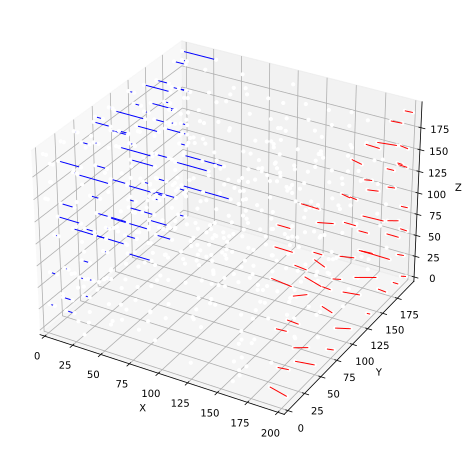

In [13]:
Ps = net.pores('right')
net.set_label('right_boundary', pores=Ps)
Ts = net.find_neighbor_throats(pores=net.pores('right_boundary'), mode='or')
net.set_label('right_boundary', throats=Ts)

fig, ax = plt.subplots(figsize=(8, 8))
op.topotools.plot_coordinates(network=net, color='w', ax=ax)
op.topotools.plot_connections(network=net,
                              throats=net.throats('right_boundary'),
                              color='r', ax=ax)
op.topotools.plot_connections(network=net,
                              throats=net.throats('left_boundary'),
                              color='b', ax=ax)

This result shows that the boundary pores added during the ``snow`` extraction (red) are randomly oriented while those added by the ``clone_pores_method`` are aligned with their internal counter-parts. It also seems like longer connections are made with the ``clone_pores_method`` which may be the result of the Delanauy tessellation identifying pores that are too deep into the domain. 